In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


## Fashion MNIST

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

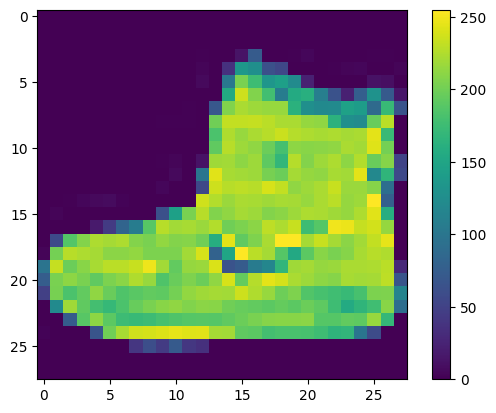

In [4]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [5]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

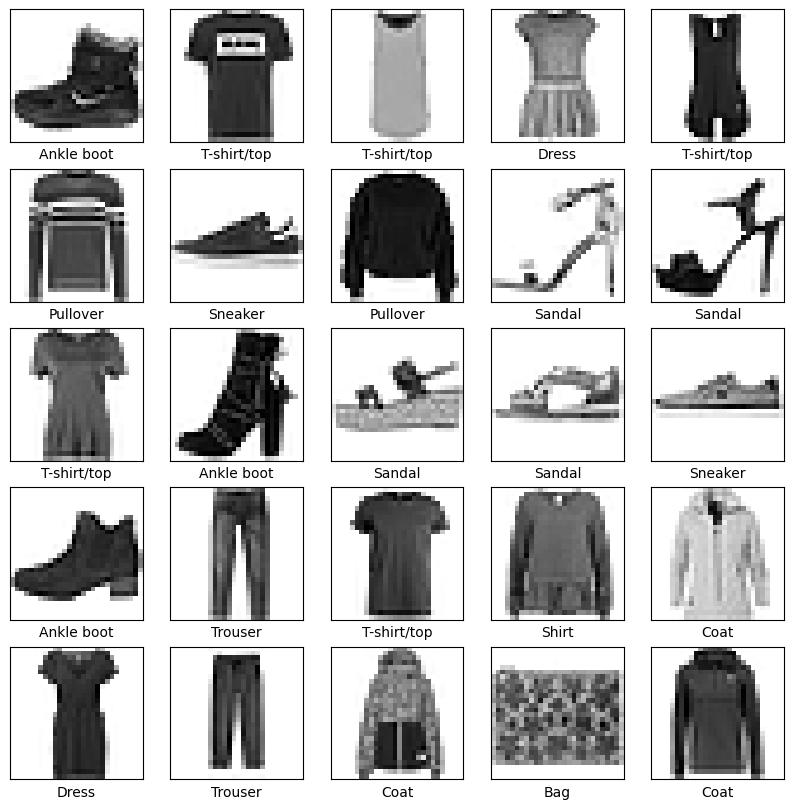

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [7]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [7]:
import tensorflow as tf

batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x1)  # Updated LSTM units to 512
x1 = tf.keras.layers.LSTM(512, name='LSTM_left')(x1)  # Updated LSTM units to 512

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x2)  # Updated LSTM units to 512
x2 = tf.keras.layers.LSTM(512, name='LSTM_right')(x2)  # Updated LSTM units to 512

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 28, 28)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 64)    │      5,440 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 28, 64)    │      5,440 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 28, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 28, 1024)  │  2,363,392 │ conv1d_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 28, 1024)  │  2,363,392 │ conv1d_3[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_left (LSTM)    │ (None, 512)       │  3,147,776 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_right (LSTM)   │ (None, 512)       │  3,147,776 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ LSTM_left[0][0],  │
│ (Concatenate)       │                   │            │ LSTM_right[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     10,250 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,068,170 (42.22 MB)

 Trainable params: 11,068,170 (42.22 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=2, batch_size=batch_size)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 565s 300ms/step - accuracy: 0.7397 - loss: 0.6901
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 540s 288ms/step - accuracy: 0.8579 - loss: 0.3864


In [9]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

In [10]:
test_loss, test_acc = model_fashion_lstm.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 30s - 97ms/step - accuracy: 0.8684 - loss: 0.3556

Test accuracy: 0.868399977684021


In [ ]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'model/Fashion_LSTM___Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_acc}.keras'

# Save the Model.
model_fashion_lstm.save(model_file_name)

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step
0.8684


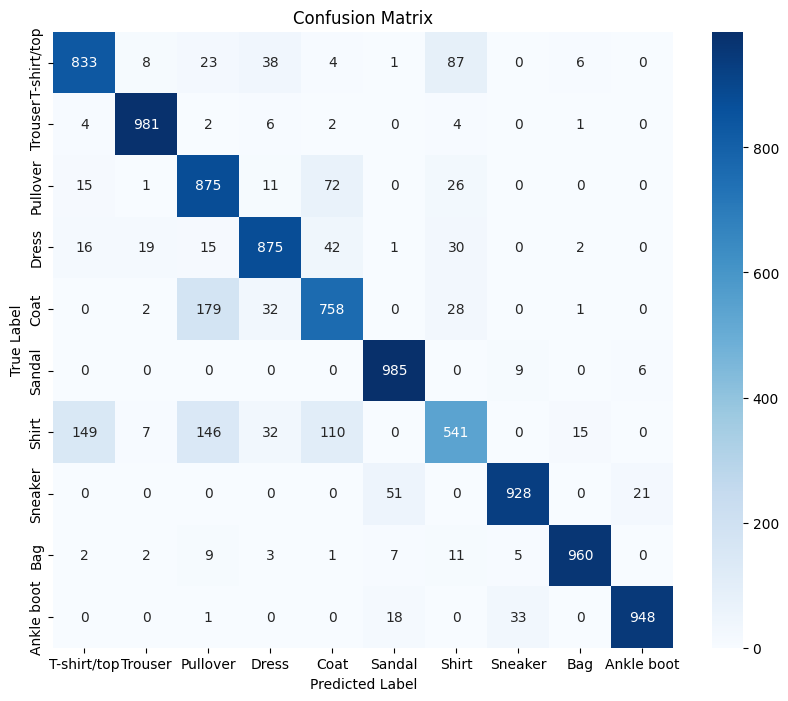

In [11]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/main')
from iterative_approximation.Algorithm1 import *

import statistics

import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [13]:
def extract_weight_array(layer):
    kernel, recurrent_kernel, bias = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [14]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel,original_layer[2]]
    
    layer.set_weights(approximated_weight)


In [16]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


0.8582

In [159]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# mse = np.linspace(0.004, 0.002, 3)
# MSE_list = mse.tolist()
MSE_list = [0.0035,0.00325,0.003,0.00275,0.0025,0.00225]

# cross cell: input and forgot gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
# cross cell: ouput and cell gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_left_weight_array[0],LSTM_left_weight_array[1]]
WW = [LSTM_right_weight_array[2],LSTM_right_weight_array[3],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step1()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W1_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]

    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# method2: group 4 approximation  
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# method3: stack matrix approximation  

W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = mean_square_error_array1(W,W1_approximated)
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = mean_square_error_array1(WW,W2_approximated)
        W_MSE = (W1_MSE + W2_MSE)/2

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# method4: hybrid approximation strategy 1
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# method4: hybrid approximation strategy 3
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W5_memory_footprints = []
W5_mses = []

W_MSE = 0.01

accuracy_result5 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(3)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(3)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W5_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result5.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# method4: hybrid approximation strategy 5
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# method4: hybrid approximation strategy 6
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
    left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

    set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
    set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14

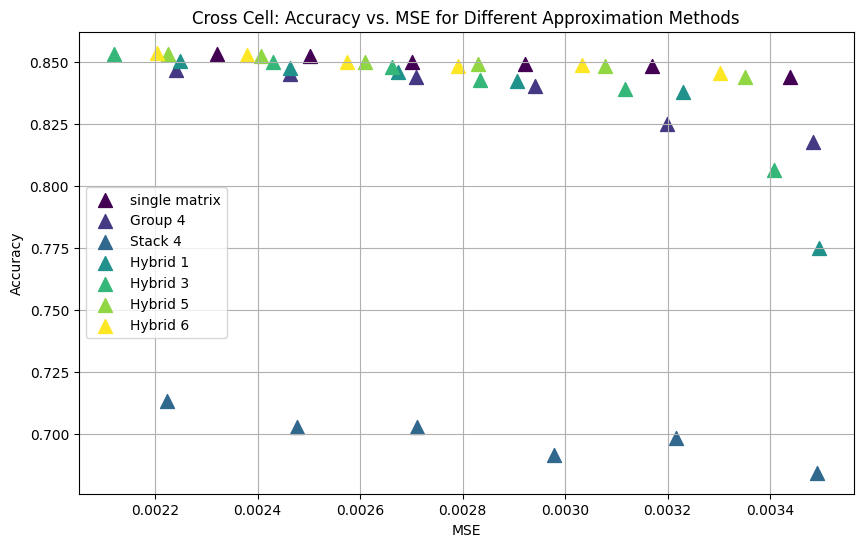

In [162]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W5_mses, W6_mses, W7_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3, accuracy_result4, accuracy_result5, accuracy_result6, accuracy_result7]
label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 3','Hybrid 5','Hybrid 6']
# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Cell: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

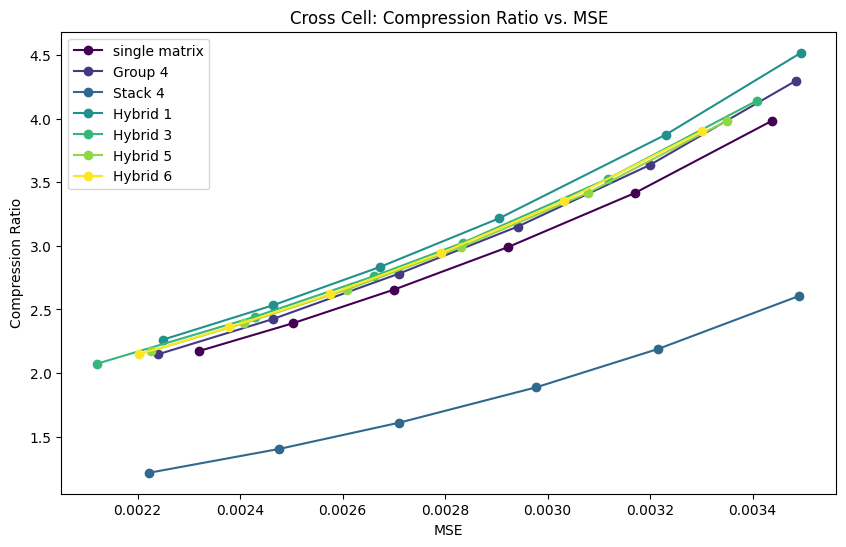

In [163]:
# Baseline memory footprint
baseline_mem_footprint = 1572864

label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 3','Hybrid 5','Hybrid 6']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W3_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W7_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints, normalized_W4_mem_footprints, normalized_W5_mem_footprints, normalized_W6_mem_footprints, normalized_W7_mem_footprints]
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W5_mses, W6_mses, W7_mses]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Cell: Compression Ratio vs. MSE')
plt.legend()
plt.show()

In [42]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# mse = np.linspace(0.004, 0.002, 3)
# MSE_list = mse.tolist()
MSE_list = [0.0035,0.00325,0.003,0.00275,0.0025,0.00225]
MSE_list = [0.0035]
# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step1()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step1()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W1_MSE)


    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

# method2: group 4 approximation  
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)


# method3: stack matrix approximation  
W1 = WeightArrayStepPruning(W,'weight',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,64,192,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = mean_square_error_array1(W,W1_approximated)
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = mean_square_error_array1(WW,W2_approximated)
        W_MSE = (W1_MSE + W2_MSE)/2

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)


# method4: hybrid approximation strategy 1
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

# method4: hybrid approximation strategy 3
# W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
# W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
# W5_memory_footprints = []
# W5_mses = []

# W_MSE = 0.01

# accuracy_result5 = []

# for MSE in MSE_list:
#     while W_MSE > MSE:
#         W1.hybrid_iterative_approximation_step(3)
#         W1_MSE = W1.average_mse_array()
#         W2.hybrid_iterative_approximation_step(3)
#         W2_MSE = W2.average_mse_array()
#         W_MSE = (W1_MSE + W2_MSE)/2

#     W1_approximated = W1.current_reconstructed_weight_array
#     W2_approximated = W2.current_reconstructed_weight_array

#     W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
#     W5_mses.append(W_MSE)

#     set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
#     set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

#     predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
#     accuracy = accuracy_score(fashion_test_labels, predicted_classes)

#     accuracy_result5.append(accuracy)

# method4: hybrid approximation strategy 5
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

# method4: hybrid approximation strategy 6
W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


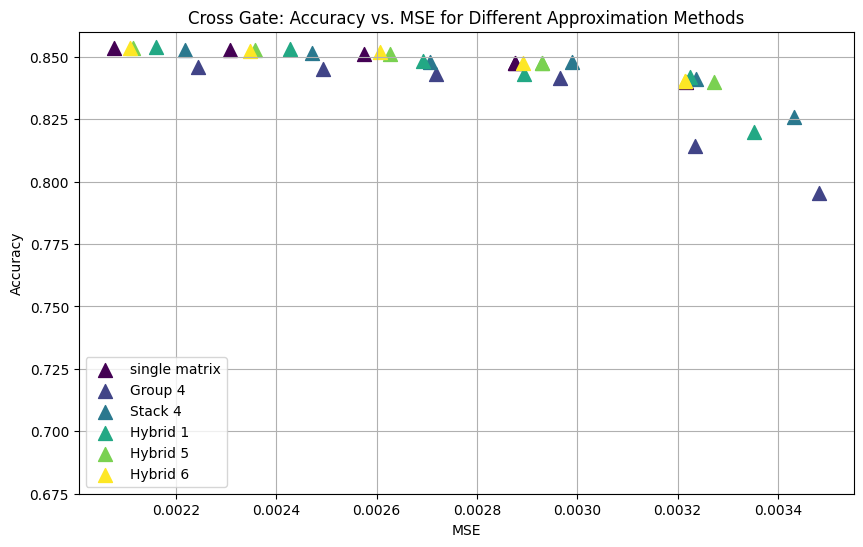

In [187]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W6_mses, W7_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3, accuracy_result4, accuracy_result6, accuracy_result7]
label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 5','Hybrid 6']
# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.ylim([0.675,0.86])
plt.grid(True)
plt.show()

In [35]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.0015]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)


Group4_W1_memory_footprints = []
Group4_W1_mses = []

W_MSE = 0.01

Group4_accuracy_result1 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step


In [36]:
Group4_accuracy_result1

[0.353]

In [37]:
W1_approximated[0][0:10,0]

array([ 0.01495237, -0.03704111, -0.03141792, -0.03370302, -0.04073288,
       -0.00915056,  0.00661081, -0.04607719,  0.01145747, -0.02946531])

In [38]:
W[0][0:10,0]

array([-0.05752649, -0.07226384, -0.05059266, -0.04126034, -0.06183823,
        0.00783346,  0.02626475, -0.02768464,  0.04420937, -0.01452815],
      dtype=float32)

In [18]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.004,0.0035,0.003,0.0025]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# method1: single matrix approximation
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)

Group4_W1_memory_footprints = []
Group4_W1_mses = []

W_MSE = 0.01

Group4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2()
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2()
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Group 4 with Frobenius norm
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
Group4_W2_memory_footprints = []
Group4_W2_mses = []

W_MSE = 0.01

Group4_accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('fro')
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2_norm('fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Group 4 with spectral norm
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
Group4_W3_memory_footprints = []
Group4_W3_mses = []

W_MSE = 0.01

Group4_accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.iterative_approximation_step2_norm('spec')
        W1_MSE = W1.average_mse_array()
        W2.iterative_approximation_step2_norm('spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    Group4_W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Group4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Group4_accuracy_result3.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step


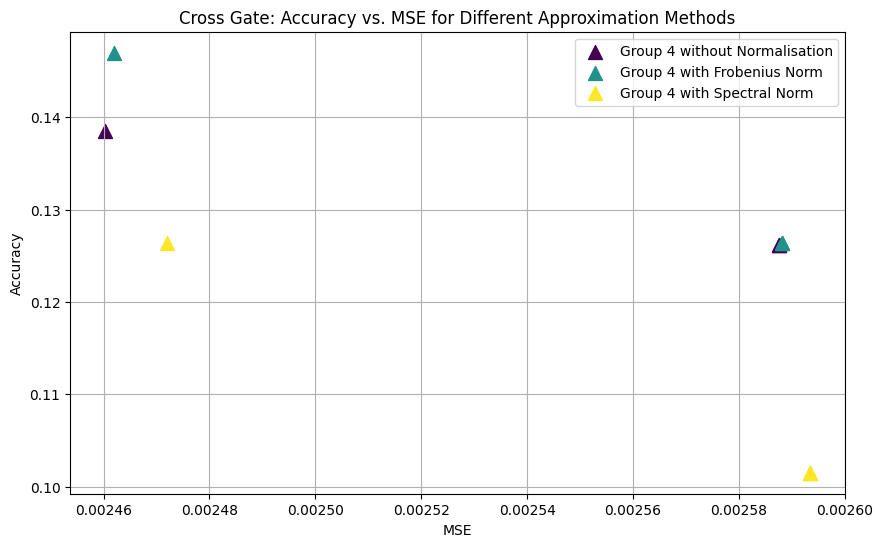

In [21]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Group4_W1_mses, Group4_W2_mses, Group4_W3_mses]
accuracy_results = [Group4_accuracy_result1, Group4_accuracy_result2, Group4_accuracy_result3]
label_list = ['Group 4 without Normalisation','Group 4 with Frobenius Norm','Group 4 with Spectral Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Cross Gate: Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.004,0.0035,0.003,0.0025]

# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# Stack 4 without normalisation
W1 = WeightArrayStepPruning(W,'weight',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,512,1536,1,1)

Stack4_W1_memory_footprints = []
Stack4_W1_mses = []

W_MSE = 0.01

Stack4_accuracy_result1 = []


for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3()
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3()
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Stack 4 with Frobenius norm
W1 = WeightArrayStepPruning(W,'weight',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,512,1536,1,1)
Stack4_W2_memory_footprints = []
Stack4_W2_mses = []

W_MSE = 0.01

Stack4_accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('fro')
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3_norm('fro')
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# Stack 4 with spectral norm
W1 = WeightArrayStepPruning(W,'weight',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'weight',0.001,512,1536,1,1)
Stack4_W3_memory_footprints = []
Stack4_W3_mses = []

W_MSE = 0.01

Stack4_accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1_approximated = W1.iterative_approximation_step3_norm('spec')
        W1_MSE = W1.average_mse_weight()
        W2_approximated = W2.iterative_approximation_step3_norm('spec')
        W2_MSE = W2.average_mse_weight()
        W_MSE = (W1_MSE + W2_MSE)/2

    Stack4_W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    Stack4_W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    Stack4_accuracy_result3.append(accuracy)


model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step
235/313 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step

KeyboardInterrupt: 

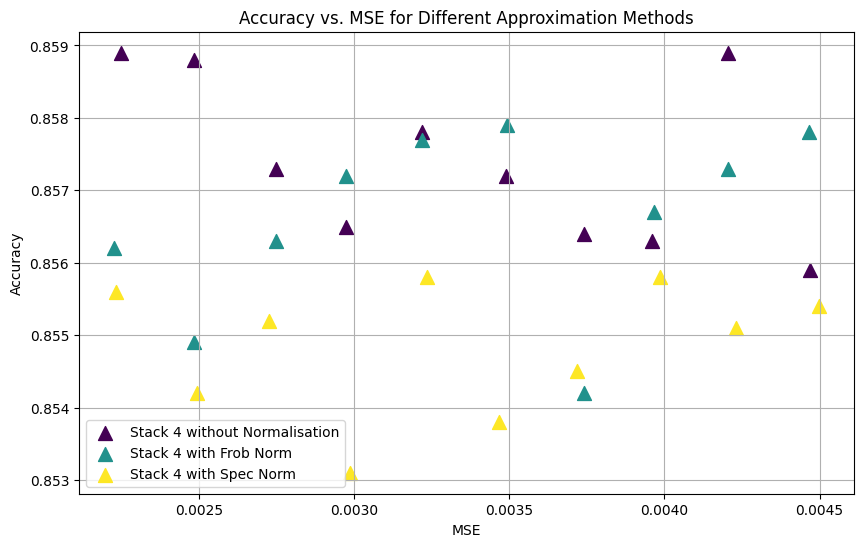

In [ ]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [Stack4_W1_mses, Stack4_W2_mses, Stack4_W3_mses]
accuracy_results = [Stack4_accuracy_result1, Stack4_accuracy_result2, Stack4_accuracy_result3]
label_list = ['Stack 4 without Normalisation','Stack 4 with Frob Norm','Stack 4 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

MSE_list = [0.004,0.0035,0.003,0.0025]
# cross gate: right LSTM
# cross gate: left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]


# hybrid 1
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W1_memory_footprints = []
W1_mses = []

W_MSE = 0.01

accuracy_result1 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(1)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(1)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W1_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W1_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result1.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W2_memory_footprints = []
W2_mses = []

W_MSE = 0.01

accuracy_result2 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(3)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(3)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W2_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W2_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result2.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# hybrid 5
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W3_memory_footprints = []
W3_mses = []

W_MSE = 0.01

accuracy_result3 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(5)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(5)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W3_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W3_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result3.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


# hybrid 6
W1 = WeightArrayStepPruning(W,'array',0.001,512,1024,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1024,1,1)
W4_memory_footprints = []
W4_mses = []

W_MSE = 0.01

accuracy_result4 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step(6)
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step(6)
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W4_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W4_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result4.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14

In [42]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# hybrid 1 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W5_memory_footprints = []
W5_mses = []

W_MSE = 0.01

accuracy_result5 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(1,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W5_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W5_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result5.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W6_memory_footprints = []
W6_mses = []

W_MSE = 0.01

accuracy_result6 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(3,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W6_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W6_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result6.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 6 normalised Frob
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W7_memory_footprints = []
W7_mses = []

W_MSE = 0.01

accuracy_result7 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'fro')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(6,'fro')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W7_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W7_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result7.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13

In [43]:
model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# hybrid 1 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W8_memory_footprints = []
W8_mses = []

W_MSE = 0.01

accuracy_result8 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(1,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(1,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W8_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W8_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result8.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 3 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W9_memory_footprints = []
W9_mses = []

W_MSE = 0.01

accuracy_result9 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(3,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(3,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W9_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W9_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result9.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

# hybrid 6 normalised spec
W1 = WeightArrayStepPruning(W,'array',0.001,512,1536,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,512,1536,1,1)
W10_memory_footprints = []
W10_mses = []

W_MSE = 0.01

accuracy_result10 = []

for MSE in MSE_list:
    while W_MSE > MSE:
        W1.hybrid_iterative_approximation_step_norm(6,'spec')
        W1_MSE = W1.average_mse_array()
        W2.hybrid_iterative_approximation_step_norm(6,'spec')
        W2_MSE = W2.average_mse_array()
        W_MSE = (W1_MSE + W2_MSE)/2

    W1_approximated = W1.current_reconstructed_weight_array
    W2_approximated = W2.current_reconstructed_weight_array

    W10_memory_footprints.append(W1.memory_footprint_compressed+W2.memory_footprint_compressed)
    W10_mses.append(W_MSE)

    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)

    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

    accuracy_result10.append(accuracy)

model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14

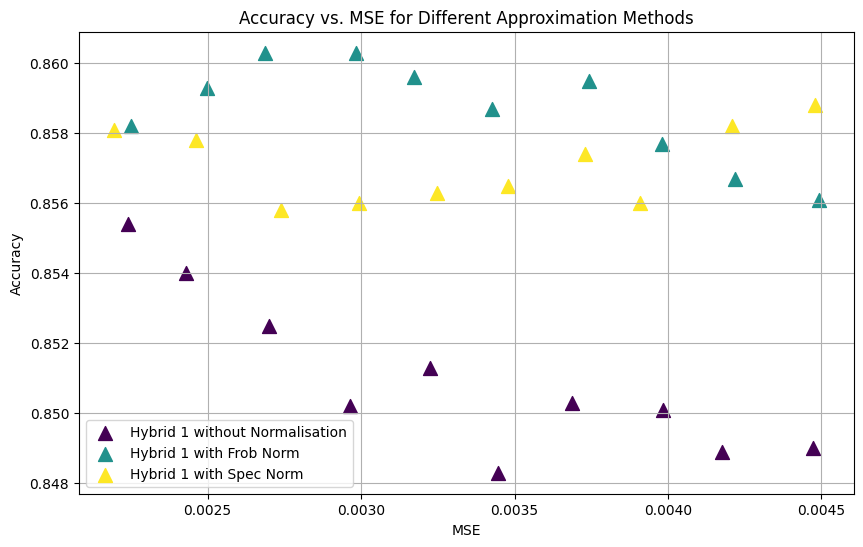

In [44]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses,W4_mses, W5_mses, W6_mses,W7_mses, W8_mses, W9_mses,W10_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3,accuracy_result4, accuracy_result5, accuracy_result6,accuracy_result7, accuracy_result8, accuracy_result9,accuracy_result10]
label_list = ['Hybrid 1 without Normalisation','Hybrid 3 without Normalisation','Hybrid 5 without Normalisation','Hybrid 6 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 3 with Frob Norm','Hybrid 6 with Frob Norm','Hybrid 1 with Spec Norm','Hybrid 3 with Spec Norm','Hybrid 6 with Spec Norm']


mse_lists = [W1_mses, W5_mses, W8_mses]
accuracy_results = [accuracy_result1, accuracy_result5, accuracy_result8]
label_list = ['Hybrid 1 without Normalisation','Hybrid 1 with Frob Norm','Hybrid 1 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend()
plt.grid(True)
plt.show()

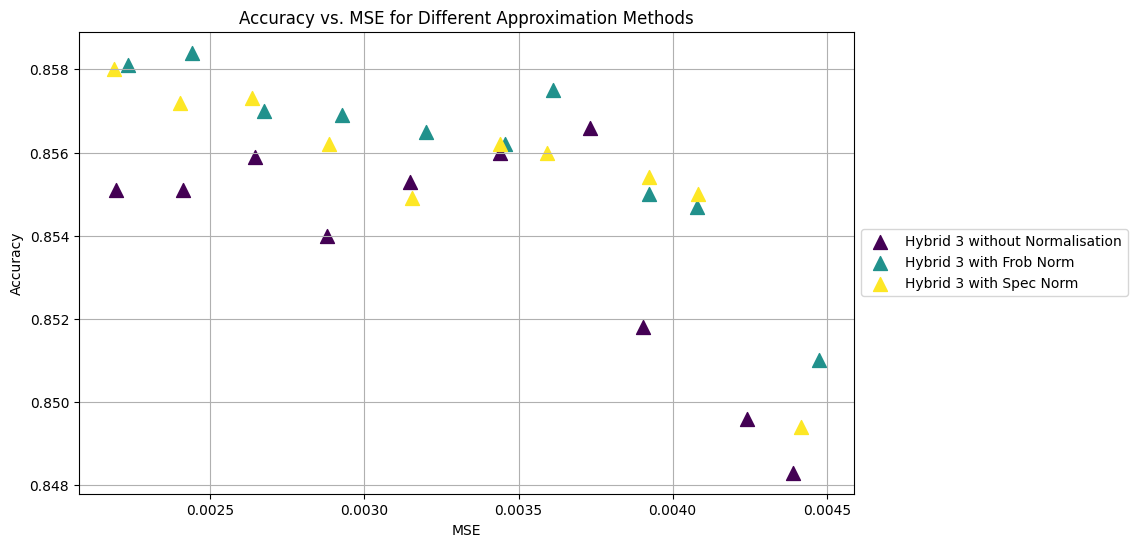

In [56]:
mse_lists = [ W2_mses, W6_mses, W9_mses]
accuracy_results = [accuracy_result2, accuracy_result6, accuracy_result9]
label_list = ['Hybrid 3 without Normalisation','Hybrid 3 with Frob Norm', 'Hybrid 3 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

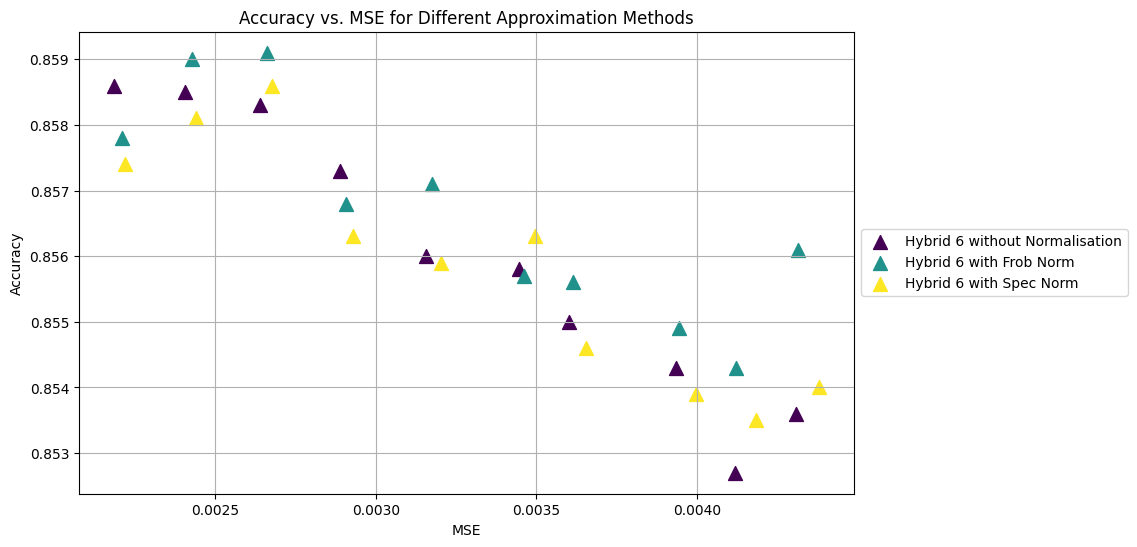

In [55]:
mse_lists = [ W4_mses, W7_mses, W10_mses]
accuracy_results = [accuracy_result4, accuracy_result7, accuracy_result10]
label_list = ['Hybrid 6 without Normalisation','Hybrid 6 with Frob Norm', 'Hybrid 6 with Spec Norm']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

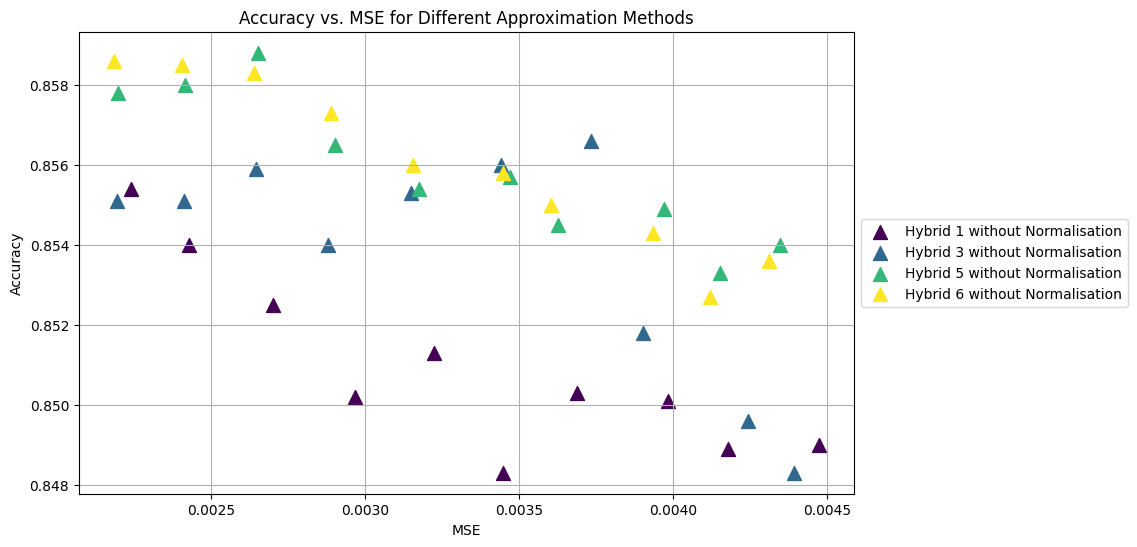

In [54]:
# Assuming W1_mses through W7_mses are defined corresponding to each accuracy_result
mse_lists = [W1_mses, W2_mses, W3_mses,W4_mses]
accuracy_results = [accuracy_result1, accuracy_result2, accuracy_result3,accuracy_result4]
label_list = ['Hybrid 1 without Normalisation','Hybrid 3 without Normalisation','Hybrid 5 without Normalisation','Hybrid 6 without Normalisation']

# Number of different plots
num_plots = len(accuracy_results)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mse_list, accuracy_result) in enumerate(zip(mse_lists, accuracy_results)):
    plt.scatter(mse_list, accuracy_result, color=colors[i], marker='^', s=100,label=f'{label_list[i]}')

plt.xlabel('MSE')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. MSE for Different Approximation Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

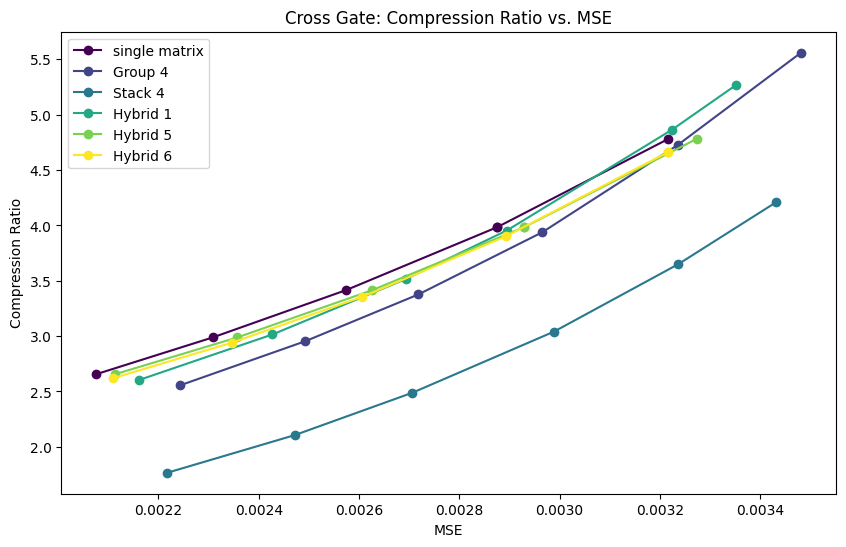

In [180]:
# Baseline memory footprint
baseline_mem_footprint = 1572864

label_list = ['single matrix','Group 4','Stack 4','Hybrid 1','Hybrid 5','Hybrid 6']

# Normalizing the memory footprints by the baseline
normalized_W1_mem_footprints = [baseline_mem_footprint/x for x in W1_memory_footprints]
normalized_W2_mem_footprints = [baseline_mem_footprint/x for x in W2_memory_footprints]
normalized_W3_mem_footprints = [baseline_mem_footprint/x for x in W3_memory_footprints]
normalized_W4_mem_footprints = [baseline_mem_footprint/x for x in W4_memory_footprints]
# normalized_W5_mem_footprints = [baseline_mem_footprint/x for x in W5_memory_footprints]
normalized_W6_mem_footprints = [baseline_mem_footprint/x for x in W6_memory_footprints]
normalized_W7_mem_footprints = [baseline_mem_footprint/x for x in W7_memory_footprints]

# Gathering all normalized memory footprints and MSEs
normalized_mem_footprints = [normalized_W1_mem_footprints, normalized_W2_mem_footprints, normalized_W3_mem_footprints, normalized_W4_mem_footprints, normalized_W6_mem_footprints, normalized_W7_mem_footprints]
mse_lists = [W1_mses, W2_mses, W3_mses, W4_mses, W6_mses, W7_mses]

# Number of different plots
num_plots = len(normalized_mem_footprints)

# Get the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, num_plots))

# Plotting
plt.figure(figsize=(10, 6))
for i, (mem_footprints, mse_list) in enumerate(zip(normalized_mem_footprints, mse_lists)):
    plt.plot(mse_list, mem_footprints, color=colors[i], marker='o', label=f'{label_list[i]}', linestyle='-')

plt.xlabel('MSE')
plt.ylabel('Compression Ratio')
plt.title('Cross Gate: Compression Ratio vs. MSE')
plt.legend()

plt.show()

In [ ]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

# cross cell: input and forgot gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
# cross cell: ouput and cell gates augmented matrices from right LSTM + input and forgot gates augmented matrices from left LSTM
W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_left_weight_array[0],LSTM_left_weight_array[1]]
WW = [LSTM_right_weight_array[2],LSTM_right_weight_array[3],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# method1: single matrix approximation
MSE = 0.0028

W1 = WeightArrayStepPruning(W,'array',0.001,64,192,1,1)
W2 = WeightArrayStepPruning(WW,'array',0.001,64,192,1,1)

W_MSE = 0.01

accuracy_result1 = []

while W_MSE > MSE:
    W1.iterative_approximation_step1()
    W1_MSE = W1.average_mse()
    W2.iterative_approximation_step1()
    W2_MSE = W2.average_mse()
    W_MSE = (W1_MSE + W2_MSE)/2

W1_approximated = W1.current_reconstructed_weight_array
W2_approximated = W2.current_reconstructed_weight_array

W1_memory_footprints = (W1.memory_footprint_compressed+W2.memory_footprint_compressed)
W1_mses = W_MSE
W1_num_group = W1.num_group

right_approximaated = [W1_approximated[0],W1_approximated[1],W2_approximated[0],W2_approximated[1]]
left_approximaated = [W1_approximated[2],W1_approximated[3],W2_approximated[2],W2_approximated[3]]

set_layer_weight(LSTM_right_layer,original_weights_right,right_approximaated)
set_layer_weight(LSTM_left_layer,original_weights_left,left_approximaated)

predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy_result1 = accuracy_score(fashion_test_labels, predicted_classes)


In [227]:
import math
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 10, 16, 32, 64]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [10, 16, 32, 64]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

# Example usage
R = 64
valid_pairs_R = generate_pairs(R)
print(valid_pairs_R)

[[2, 16], [2, 24], [2, 32], [4, 8], [4, 12], [4, 16], [8, 4], [8, 6], [8, 8], [10, 3], [10, 4], [10, 5], [10, 6], [16, 2], [16, 3], [16, 4], [32, 1], [32, 2], [64, 1]]


In [228]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32, 64, 192]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 16 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 192]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs

# Example usage
C = 192
valid_pairs_C = generate_pairs2(C)
print(valid_pairs_C)

[[2, 48], [2, 64], [2, 80], [2, 96], [8, 12], [8, 16], [8, 20], [8, 24], [16, 6], [16, 7], [16, 8], [16, 9], [16, 10], [16, 11], [16, 12], [32, 3], [32, 4], [32, 5], [32, 6], [64, 2], [64, 3], [192, 1]]


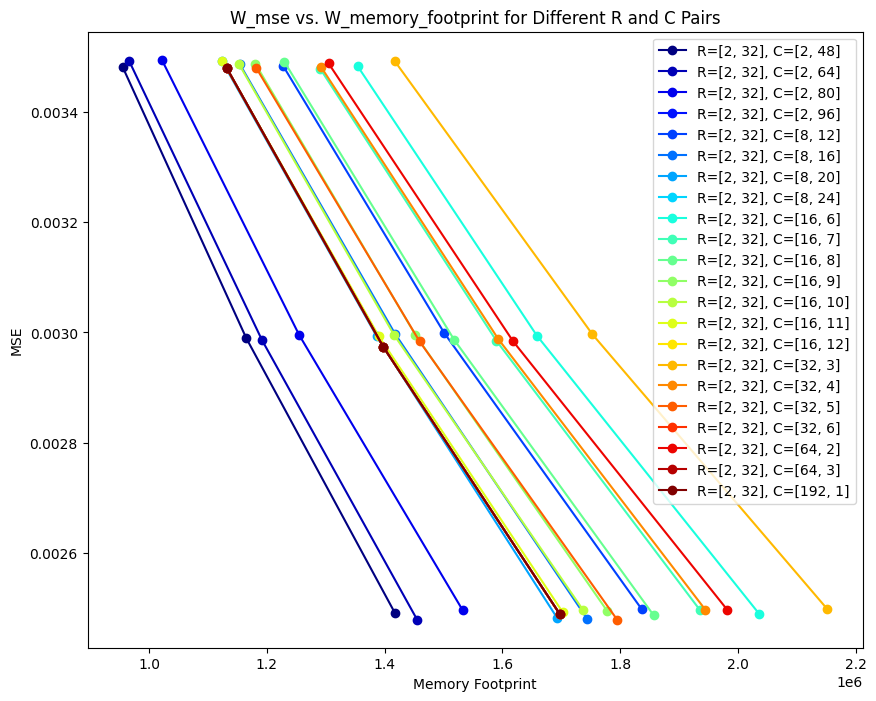

In [236]:
LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

# Generate a color map to differentiate the pair_R and pair_C combinations
colors = plt.cm.jet(np.linspace(0, 1, len(valid_pairs_R[2:3]) * len(valid_pairs_C)))

color_index = 0

plt.figure(figsize=(10, 8))

for pair_R in valid_pairs_R[2:3]:
    for pair_C in valid_pairs_C:
        # Initialize W1 and W2 with the pruning parameters
        W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
        W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

        W_MSE = 0.01
        MSE_list = [0.0035, 0.003, 0.0025]

        W_mses = []
        W_memory_footprint = []

        # Iterate through MSE targets
        for MSE in MSE_list:
            while W_MSE > MSE:
                W1.iterative_approximation_step2()
                W1_MSE = W1.average_mse()
                W2.iterative_approximation_step2()
                W2_MSE = W2.average_mse()
                W_MSE = (W1_MSE + W2_MSE) / 2

            W_mses.append(W_MSE)
            W_memory_footprint.append(W1.memory_footprint_compressed + W2.memory_footprint_compressed)

        # Plot the results with the corresponding color
        plt.plot(W_memory_footprint, W_mses, marker='o', color=colors[color_index], label=f'R={pair_R}, C={pair_C}')
        color_index += 1

plt.xlabel('Memory Footprint')
plt.ylabel('MSE')
plt.title('W_mse vs. W_memory_footprint for Different R and C Pairs')
plt.legend()
plt.show()

        